## Bivariate EDA (Behavior ↔ Psychology)

### Objective
Analyze associations between aggregated email behavior and psychometric traits at the user level.
This analysis is descriptive only — no causality, no detection claims.

### 1. Load Data & Validate Join Level

In [18]:
import os
import sys

sys.path.append(os.path.abspath(".."))

In [19]:
from src.data_utils import load_raw, save_processed
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

df=load_raw("email.csv")
df1=load_raw("psychometric.csv")

In [20]:
df['user'].nunique(), df1['user_id'].nunique()

(1000, 1000)

#### Observation:

- Both the email and psychometric datasets contain 1,000 unique users, enabling a valid one-to-one join at the user level.

- All subsequent analysis is restricted to this aligned population to avoid partial joins or sampling bias.

### 2. Aggregate Email Behavior at User Level

In [21]:
df['date_only']=pd.to_datetime(df['date']).dt.date

In [22]:
email_user_agg=df.groupby('user').agg(
    total_emails=('id', 'count'),
    avg_email_size=('size', 'mean'),
    total_attachment=('attachments', 'sum'),
    active_days=('date_only','nunique'),
).reset_index()

In [23]:
email_user_agg['emails_per_day']=email_user_agg['total_emails']/email_user_agg['active_days']

In [24]:
email_user_agg.shape, email_user_agg['user'].nunique()

((1000, 6), 1000)

#### Observation:

- Email activity was aggregated at the user level to summarize individual communication behavior across the observation period.

- Aggregation reduces event-level noise and enables meaningful comparison with static psychometric traits.

### 3.Merge with Psychometric Data (One-to-One)

In [25]:
df_merge=pd.merge(
    email_user_agg, 
    df1, left_on='user', 
    right_on='user_id', 
    how='inner', 
    validate='one_to_one'
)

In [26]:
df_merge.shape, df_merge['user'].nunique()


((1000, 13), 1000)

#### Observation:

- Aggregated email metrics were successfully merged with psychometric traits using a one-to-one user mapping.

### 4. Correlation Analysis (Behavior ↔ Traits)

In [27]:
df_merge.columns

Index(['user', 'total_emails', 'avg_email_size', 'total_attachment',
       'active_days', 'emails_per_day', 'employee_name', 'user_id', 'O', 'C',
       'E', 'A', 'N'],
      dtype='object')

In [30]:
corr_cols=[
    'total_emails', 
    'avg_email_size', 
    'total_attachment',
    'active_days', 
    'emails_per_day', 
    'O', 'C','E', 'A', 'N'
]

corr=df_merge[corr_cols].corr()

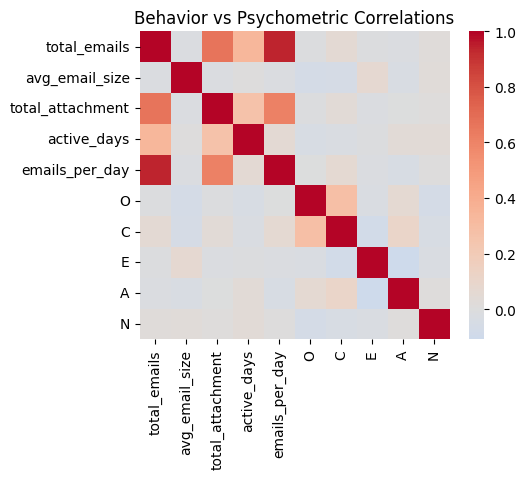

In [32]:
plt.figure(figsize=(5,4))
sns.heatmap(corr, cmap='coolwarm', center=0)
plt.title('Behavior vs Psychometric Correlations')
plt.show()

#### Observation:

- Correlation analysis shows generally weak linear relationships between communication volume metrics and psychometric traits.

- No single trait demonstrates a strong or dominant association with email behavior.

### 5. Trait Extremes vs Communication Volume

In [33]:
trait=['O', 'C', 'E', 'A', 'N']

results={}

for i in trait:
    high=df_merge[i]>df_merge[i].quantile(0.75)
    low=df_merge[i]<df_merge[i].quantile(0.25)

    results[i]={
        'high_trait_avg_emails': df_merge.loc[high, 'total_emails'].mean(),
        'low_trait_avg_emails': df_merge.loc[low, 'total_emails'].mean()
    }
pd.DataFrame(results).T

,high_trait_avg_emails,low_trait_avg_emails
O,2532.644550,2646.491597
C,2762.231092,2652.645299
E,2638.861345,2658.217593
A,2660.420833,2629.590308
N,2713.420091,2514.527638


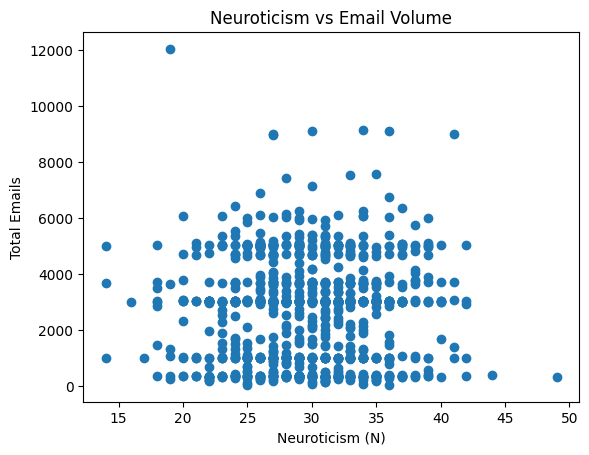

In [36]:
plt.scatter(df_merge['N'], df_merge['total_emails'])
plt.xlabel("Neuroticism (N)")
plt.ylabel("Total Emails")
plt.title("Neuroticism vs Email Volume")
plt.show()

#### Observation:

- Comparing users in the highest and lowest quartiles of each psychometric trait reveals modest differences in communication volume.

- Neuroticism shows the largest separation, with higher email activity observed among high-N users, while other traits exhibit minimal separation.

### 6. Outlier Communication vs Traits

In [37]:
threshold = df_merge['total_emails'].quantile(0.95)

outliers = df_merge[df_merge['total_emails'] >= threshold]
non_outliers = df_merge[df_merge['total_emails'] < threshold]

outlier_trait_means = pd.DataFrame({
    'outliers': outliers[['O','C','E','A','N']].mean(),
    'non_outliers': non_outliers[['O','C','E','A','N']].mean()
})

outlier_trait_means

,outliers,non_outliers
O,31.32,33.270526
C,29.88,30.693684
E,29.40,29.186316
A,28.46,28.840000
N,29.96,29.589474


#### Observation:

- High-volume communication outliers do not exhibit substantial psychometric differences compared to non-outliers.

- Trait distributions between the two groups are largely similar, suggesting that extreme email activity alone is not strongly linked to personality differences.

#### Final Interpretation (ONE closing note only)

- All observed relationships are associative and exploratory in nature.

- These findings do not indicate malicious behavior or insider risk and should be interpreted within organizational and role-based context.

In [39]:
save_processed(df_merge, 'user_level_bivariate_features_v2.csv')